## Prediction weather Marvel carachter is female

In [90]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

### Loading data

In [95]:
with zipfile.ZipFile('data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [96]:
df_marvel = pd.read_csv('data/marvel-wikia-data.csv')
df_dc = pd.read_csv('data/dc-wikia-data.csv')

In [97]:
df_marvel.shape, df_dc.shape

((16376, 13), (6896, 13))

* Mismatch in column naming.
* renaming them

In [98]:
print("Columns in df1 but not in df2:", set(df_marvel.columns) - set(df_dc.columns))
print("Columns in df2 but not in df1:", set(df_dc.columns) - set(df_marvel.columns))

Columns in df1 but not in df2: {'Year'}
Columns in df2 but not in df1: {'YEAR'}


In [99]:
df_marvel.loc[600:620]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year
600,104599,Lily Hollister (Earth-616),\/Lily_Hollister_(Earth-616),Public Identity,Bad Characters,Brown Eyes,Black Hair,Female Characters,NaN,Living Characters,64.0,Jan-08,2008.0
601,2502,Tyr Odinson (Earth-616),\/Tyr_Odinson_(Earth-616),Secret Identity,Bad Characters,Blue Eyes,Black Hair,Male Characters,NaN,Deceased Characters,63.0,Oct-62,1962.0
602,1941,Krang (Earth-616),\/Krang_(Earth-616),Secret Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,63.0,Sep-63,1963.0
603,2316,Zebediah Killgrave (Earth-616),\/Zebediah_Killgrave_(Earth-616),Public Identity,Bad Characters,Purple Eyes,Purple Hair,Male Characters,NaN,Living Characters,63.0,Oct-64,1964.0
604,1738,En Dwi Gast (Earth-616),\/En_Dwi_Gast_(Earth-616),Secret Identity,Bad Characters,Red Eyes,White Hair,Male Characters,NaN,Living Characters,63.0,Oct-69,1969.0
605,16087,Arthur Stacy (Earth-616),\/Arthur_Stacy_(Earth-616),NaN,Good Characters,Blue Eyes,Grey Hair,Male Characters,NaN,Living Characters,63.0,Feb-71,1971.0
606,37421,David Griffith (Earth-616),\/David_Griffith_(Earth-616),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,63.0,Aug-72,1972.0
607,1739,Franklin Hall (Earth-616),\/Franklin_Hall_(Earth-616),Public Identity,Bad Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,63.0,Apr-77,1977.0
608,16580,Microtron (Earth-616),\/Microtron_(Earth-616),NaN,NaN,NaN,NaN,NaN,NaN,Living Characters,63.0,Jan-79,1979.0
609,26827,Sara Wolfe (Earth-616),\/Sara_Wolfe_(Earth-616),Public Identity,Good Characters,NaN,Black Hair,Female Characters,NaN,Living Characters,63.0,Dec-79,1979.0


In [100]:
df_marvel.rename(columns={'Year': 'YEAR'}, inplace=True)

* Concatenating two dataframes into one full 

In [101]:
df_full = pd.concat([df_marvel, df_dc], axis=0, ignore_index=True)

In [102]:
df_full.columns = df_full.columns.str.lower().str.replace(' ', '_')

In [103]:
df_full.describe().T

,count,mean,std,min,25%,50%,75%,max
page_id,23272.0,254956.821932,231417.093079,1025.0,31385.75,192263.5,456337.75,755278.0
appearances,21821.0,19.009303,93.814040,1.0,1.00,4.0,10.00,4043.0
year,22388.0,1986.420046,18.972698,1935.0,1976.00,1990.0,2001.00,2013.0


* Dropping unneed comlums
* urlslug - is the same as characters' name, GSM has more than 95% missing values

In [104]:
df_full = df_full.drop(['gsm','urlslug','year'], axis=1)

* Splitting name column into name and real_name

In [105]:
#df_full[['name', 'real_name']] = df_full['name'].str.extract(r'(.+?) \((.+?)\)')

* Checking for dublicates based on page_id, which is charackters' unique identifier from wiki

In [106]:
duplicates = df_full[df_full.duplicated(subset=['page_id','name'])]
duplicates

,page_id,name,id,align,eye,hair,sex,alive,appearances,first_appearance


* Page ids are not unique. We have two different characters from different sources that have same page_id

In [107]:
df_full[df_full['page_id'] == 1576]

,page_id,name,id,align,eye,hair,sex,alive,appearances,first_appearance
223,1576,Ultron (Earth-616),No Dual Identity,Bad Characters,Red Eyes,No Hair,Male Characters,Deceased Characters,181.0,Jul-68
16380,1576,Richard Grayson (New Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,"1940, April"


* Bring column with different formats of time to one common datestamp format

In [108]:
def parse_dates(date):
    if isinstance(date, str):  # Check if the value is a string
        try:
            # Handle the 'Sep-64' format
            if '-' in date:  
                month, year = date.split('-')
                
                # Convert the year based on assumed century
                if int(year) < 30:   # Assume 21st century for years like '00' - '39'
                    year = '20' + year
                else:                # Assume 20th century for years '40' - '99'
                    year = '19' + year
                    
                return pd.to_datetime(f'{month}-{year}', format='%b-%Y')
            
            # Handle the '1971, June' type format
            else:
                return pd.to_datetime(date, format='%Y, %B')
                
        except ValueError:
            return pd.NaT  # Return NaT for any dates that don’t match either format
    return pd.NaT

In [109]:
df_full['first_appearance'] = df_full['first_appearance'].apply(parse_dates)

In [119]:
df_full['first_appearance'] = pd.to_datetime(df_full['first_appearance'])

In [110]:
df_full.isnull().sum()

page_id                 0
name                    0
id                   5783
align                3413
eye                 13395
hair                 6538
sex                   979
alive                   6
appearances          1451
first_appearance     1030
dtype: int64

* Getting rid of very small fraction of multiclass target variables, to bring it to binary classification problem

In [111]:
values_to_drop_from_target = [
    'Agender Characters', 
    'Genderless Characters', 
    'Genderfluid Characters', 
    'Transgender Characters'
]

* Dropping rows where: 
- half and more of the features are missing 
- missing target variable

In [112]:
df_full = df_full.dropna(thresh=7)
df_full = df_full[~df_full['sex'].isin(values_to_drop_from_target)]
df_full = df_full.dropna(subset=['sex'])

In [113]:
df_dc.shape, df_marvel.shape, df_full.shape

((6896, 13), (16376, 13), (21283, 10))

In [114]:
numerical = ['appearances']

In [115]:
categorical = ['id','align','eye','hair','alive']

* Dealing with missing values

In [116]:
#df_full[numerical] = df_full[numerical].fillna(df_full[numerical].mean())
df_full[numerical] = df_full[numerical].fillna(0)

In [117]:
df_full[categorical] = df_full[categorical].apply(lambda x: x.fillna(x.mode()[0]))

In [118]:
df_full.sex.value_counts(normalize=True)

sex
Male Characters      0.738007
Female Characters    0.261993
Name: proportion, dtype: float64

In [120]:
df_full.head()

,page_id,name,id,align,eye,hair,sex,alive,appearances,first_appearance
0,1678,Spider-Man (Peter Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,Living Characters,4043.0,1962-08-01
1,7139,Captain America (Steven Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,Living Characters,3360.0,1941-03-01
2,64786,"Wolverine (James \""Logan\"" Howlett)",Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3061.0,1974-10-01
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2961.0,1963-03-01
4,2460,Thor (Thor Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Living Characters,2258.0,1950-11-01


* Coverting target: Female Characters into numeric positive class: 1 

In [121]:
df_full.sex = (df_full.sex == 'Female Characters').astype(int)

In [122]:
df_full.loc[1110:1115]

,page_id,name,id,align,eye,hair,sex,alive,appearances,first_appearance
1110,16067,Lynn Michaels (Earth-616),Secret Identity,Good Characters,Blue Eyes,Blond Hair,1,Living Characters,34.0,1992-09-01
1111,16598,Tigon Liger (Earth-616),Secret Identity,Good Characters,Blue Eyes,Blond Hair,0,Living Characters,34.0,1992-06-01
1112,92171,Suzi Endo (Earth-616),Secret Identity,Good Characters,Brown Eyes,Black Hair,1,Living Characters,34.0,1994-12-01
1113,78887,Jessica Carradine (Earth-616),Public Identity,Good Characters,Brown Eyes,Black Hair,1,Living Characters,34.0,1996-05-01
1114,16452,Nicholas Gleason (Earth-616),Secret Identity,Good Characters,Brown Eyes,Brown Hair,0,Deceased Characters,34.0,2002-10-01
1115,194000,Barack Obama (Earth-616),No Dual Identity,Good Characters,Brown Eyes,Black Hair,0,Living Characters,34.0,2009-03-01


In [123]:
df_full.dtypes

page_id                      int64
name                        object
id                          object
align                       object
eye                         object
hair                        object
sex                          int64
alive                       object
appearances                float64
first_appearance    datetime64[ns]
dtype: object

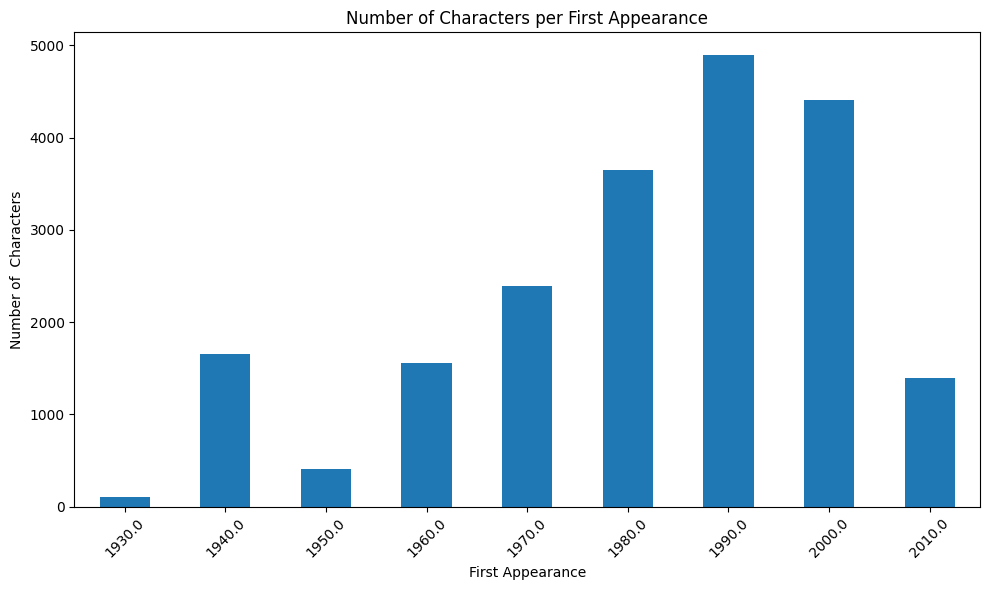

In [126]:
df_full_plot = df_full.copy()
df_full_plot['year'] = df_full_plot['first_appearance'].dt.year

df_full_plot['decade'] = (df_full_plot['year'] // 10) * 10

# Group by year and count unique 'id' values
grouped = df_full_plot.groupby('decade')['page_id'].nunique()

plt.figure(figsize=(10,6))
grouped.plot(kind='bar')
plt.title('Number of Characters per First Appearance')
plt.xlabel('First Appearance')
plt.ylabel('Number of  Characters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [127]:
df_full = df_full.drop(['page_id'], axis=1)

## Setting up the validation framework

* Perform the train/validation/test split with Scikit-Learn

In [128]:
df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [129]:
len(df_train), len(df_val), len(df_test)

(12769, 4257, 4257)

In [130]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [131]:
y_train = df_train.sex.values
y_val = df_val.sex.values
y_test = df_test.sex.values

del df_train['sex']
del df_val['sex']
del df_test['sex']

In [132]:
df_full_train = df_full_train.reset_index(drop=True)

In [133]:
df_full_train.sex.value_counts(normalize=True)

sex
0    0.736932
1    0.263068
Name: proportion, dtype: float64

## Categorical Features Correlation

In [134]:
df_full[categorical].nunique()

id        5
align     4
eye      26
hair     28
alive     2
dtype: int64

In [135]:
df_encoded = pd.get_dummies(df_full[categorical])

In [136]:
df_encoded['sex'] = df_full.sex

In [137]:
correlations = df_encoded.corr()['sex'].drop('sex')  # Drop self-correlation
print("Correlation of categorical features with target:")
print(correlations.sort_values(ascending=False))


Correlation of categorical features with target:
hair_Blond Hair              0.147257
hair_Red Hair                0.133078
align_Good Characters        0.127199
eye_Green Eyes               0.109664
alive_Living Characters      0.057434
                               ...   
alive_Deceased Characters   -0.057434
hair_Black Hair             -0.071854
hair_No Hair                -0.079465
hair_Bald                   -0.095130
align_Bad Characters        -0.152351
Name: sex, Length: 65, dtype: float64


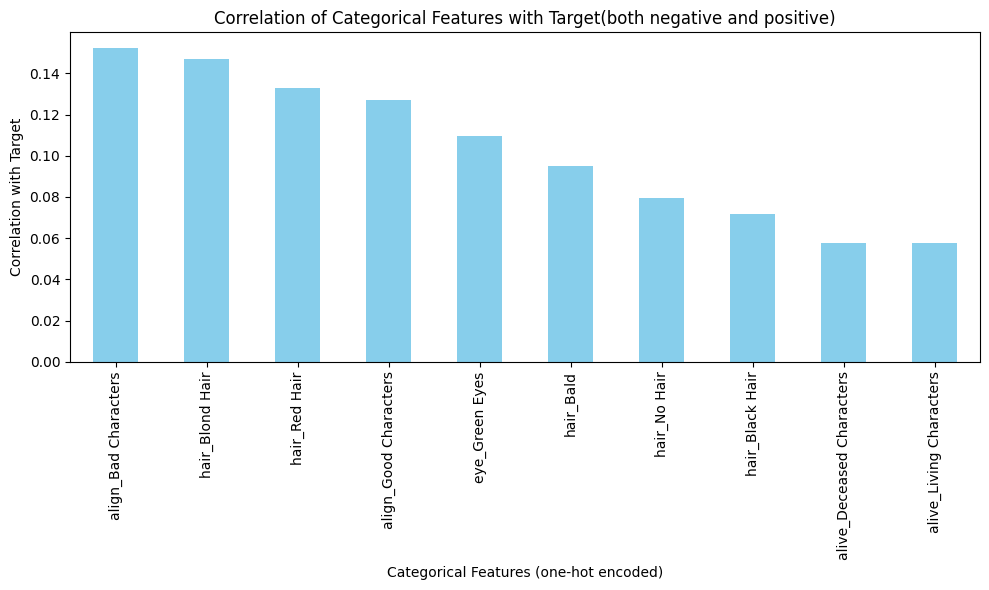

In [138]:
top_10_features = correlations.abs().sort_values(ascending=False).head(10)


plt.figure(figsize=(10, 6))
top_10_features.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Correlation of Categorical Features with Target(both negative and positive)')
plt.xlabel('Categorical Features (one-hot encoded)')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability

# Show plot
plt.tight_layout()
plt.show()

## LogisticRegression

In [139]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [140]:
model = LogisticRegression(C=0.001, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000)

In [141]:
y_pred = model.predict_proba(X_val)[:, 1]

In [142]:
roc_auc_score(y_val,y_pred)

np.float64(0.6518052017989433)

* 65% accuracy in LogisticRegression

## Decision trees


In [143]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [144]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.6620220647095638)

* Slite improvement. 66% accuracy in DecisionTreeClassifier

## RandomForestClassifier
* Here I decided to narrow down into parameters tuning

In [145]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [146]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

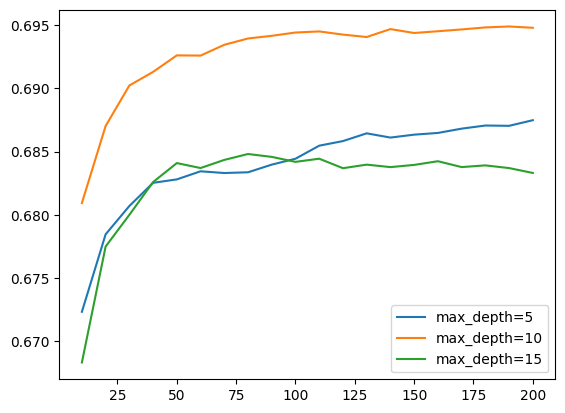

In [147]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [148]:
max_depth = 10

In [149]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [150]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

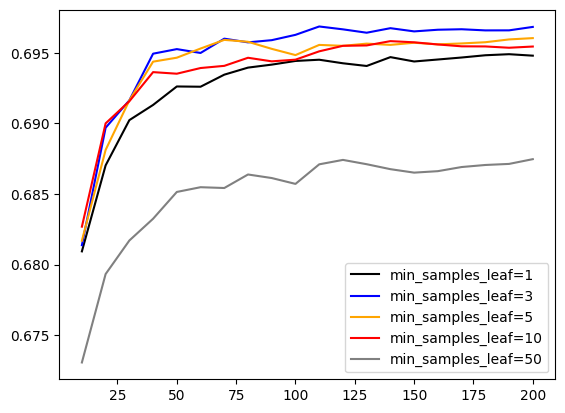

In [151]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [152]:
min_samples_leaf = 3

* Training model based on tunned parameters

In [153]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [154]:
y_pred = rf.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred),4)

np.float64(0.6968)

## XGBoost

In [155]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [156]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 2,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=20)

In [157]:
y_pred = model.predict(dval)

In [158]:
roc_auc_score(y_val, y_pred)

np.float64(0.695414149941054)

In [159]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [160]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [161]:
s = output.stdout

In [162]:
print(s[:200])

[0]	train-auc:0.68006	val-auc:0.66532
[5]	train-auc:0.70914	val-auc:0.68805
[10]	train-auc:0.72314	val-auc:0.69525
[15]	train-auc:0.73040	val-auc:0.69513
[20]	train-auc:0.73375	val-auc:0.69574
[25]	tr


In [163]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [164]:
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.68006,0.66532
1,5,0.70914,0.68805
2,10,0.72314,0.69525
3,15,0.73040,0.69513
4,20,0.73375,0.69574
5,25,0.73783,0.69644
6,30,0.74134,0.69768
7,35,0.74592,0.69472
8,40,0.74784,0.69456
9,45,0.74973,0.69251


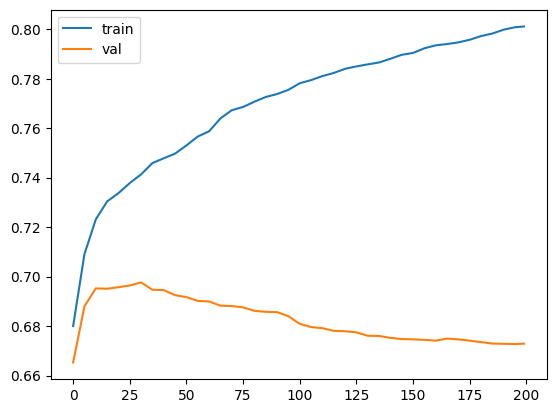

In [165]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

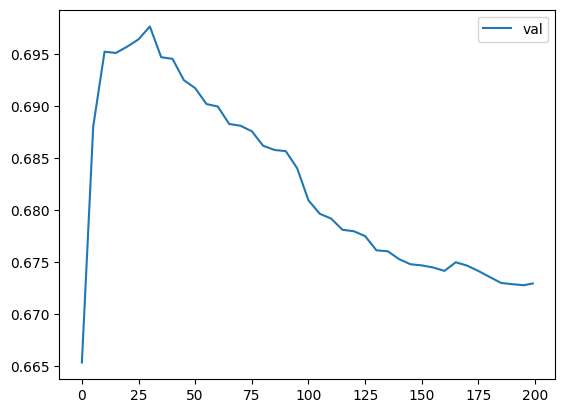

In [166]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## XGBoost parameter tuning

In [167]:
scores = {}

In [168]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
scores = {}

: 

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

: 

In [ ]:
scores = {}

: 

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

: 

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

: 

In [ ]:
del scores['max_depth=10']

: 

In [ ]:
df_score

,num_iter,train_auc,val_auc
0,0,0.68006,0.66532
1,5,0.70914,0.68805
2,10,0.72314,0.69525
3,15,0.73040,0.69513
4,20,0.73375,0.69574
5,25,0.73783,0.69644
6,30,0.74134,0.69768
7,35,0.74592,0.69472
8,40,0.74784,0.69456
9,45,0.74973,0.69251


: 

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

: 

In [ ]:
y_pred = model.predict(dval)
round(roc_auc_score(y_val, y_pred),3)

np.float64(0.702)

: 

* XGBoost Gave only 1% improvement compare to RandomForestClassifier. So I decided to use RandomForestClassifier in the end with following parameters:

* n_estimators=200
* max_depth=3
* min_samples_leaf=10
* random_state=1
